In [1]:
import tskit
import msprime
import numpy as np
import itertools
import matplotlib.pyplot as plt
import demes
import scipy.special as scs

from matplotlib.colors import to_rgb, to_rgba
from tqdm import tqdm
from runsmc import liknb as liknb
from runsmc import likstepwise as likstepwise
from runsmc import likslice as likslice

In [2]:
def simplify_keeping_unary_in_coal(ts, map_nodes=False):
    """
    Keep the unary regions of nodes that are coalescent at least someone in the tree seq
    Temporary hack until https://github.com/tskit-dev/tskit/issues/2127 is addressed
    """
    tables = ts.dump_tables()
    # remove existing individuals. We will reinstate them later
    tables.individuals.clear()
    tables.nodes.individual = np.full_like(tables.nodes.individual, tskit.NULL)

    _, node_map = ts.simplify(map_nodes=True)
    keep_nodes = np.where(node_map != tskit.NULL)[0]
    # Add an individual for each coalescent node, so we can run
    # simplify(keep_unary_in_individuals=True) to leave the unary portions in.
    for u in keep_nodes:
        i = tables.individuals.add_row()
        tables.nodes[u] = tables.nodes[u].replace(individual=i)
    node_map = tables.simplify(keep_unary_in_individuals=True, filter_individuals=False)

    # Reinstate individuals
    tables.individuals.clear()
    for i in ts.individuals():
        tables.individuals.append(i)
    val, inverted_map = np.unique(node_map, return_index=True)
    inverted_map = inverted_map[val != tskit.NULL]
    tables.nodes.individual = ts.tables.nodes.individual[inverted_map]
    if map_nodes:
        return tables.tree_sequence(), node_map
    else:
        return tables.tree_sequence()

In [3]:
def compute_liks_hudson(ts, rec_rate, ne_array):
    results = np.zeros(ne_array.size)
    for i in tqdm(range(ne_array.size)):
        results[i] = msprime.log_arg_likelihood(
            ts, 
            rec_rate, 
            ne_array[i]
        )
    return results 

def compute_liks_smc(ts, rec_rate, ne_array):
    results = np.zeros(ne_array.size)
    for i in tqdm(range(ne_array.size)):
        results[i] = liknb.log_likelihood_descending_numba(
            ts, 
            rec_rate, 
            ne_array[i],
        )
    return results

def compute_liks_smc_var_ne(ts, rec_rate, ne_array):
    results = np.zeros(ne_array.size)
    for i in tqdm(range(ne_array.size)):
        ne_steps = np.array([ne_array[i]])
        time_steps = np.zeros(1)
        results[i] = likstepwise.log_likelihood_stepwise_ne(
            ts, 
            rec_rate, 
            ne_steps, 
            time_steps, 
            )
            
    return results

def compute_liks(ts, rec_rate, ne_array, results):
    results[0] = compute_liks_hudson(ts, rec_rate, ne_array),
    results[1] = compute_liks_smc(ts, rec_rate, ne_array)

# Variable Ne / 3 slices

In [10]:
stop_times = [0, 1000, 5_000, np.inf]
ne_values = [10_000, 5000, 10_000]
ts_list = []
ts = msprime.sim_ancestry(
        samples=20,
        recombination_rate=REC_RATE,
        sequence_length=L,
        coalescing_segments_only=False,
        random_seed=SEED,
        population_size=ne_values[0],
        discrete_genome=False,
        end_time=stop_times[1]
    )
ts_list.append(ts)
for stop_time, ne_value in zip(stop_times[2:], ne_values[1:]):
    temp = msprime.sim_ancestry(
        initial_state=ts_list[-1],
        recombination_rate=REC_RATE,
        coalescing_segments_only=False,
        random_seed=SEED,
        discrete_genome=False,
        end_time=stop_time,
        population_size=ne_value
    )
    ts_list.append(temp)

In [11]:
lik_smc_slice = np.zeros((len(ts_list), ne_range.size), dtype=np.float64)
log_post_smc_slice = np.zeros_like(lik_smc_slice) 
for i in range(len(ts_list)):
    slice_time = [stop_times[i], stop_times[i+1]]
    for j in range(ne_range.size):
        lik_smc_slice[i,j] = likslice.log_likelihood(ts_list[i], REC_RATE, ne_range[j], slice_time)
    print(slice_time)
    log_post_smc_slice[i] = lik_smc_slice[i] + prior - scs.logsumexp(lik_smc_slice[i] + prior)

[0, 1000]
[1000, 5000]
[5000, inf]


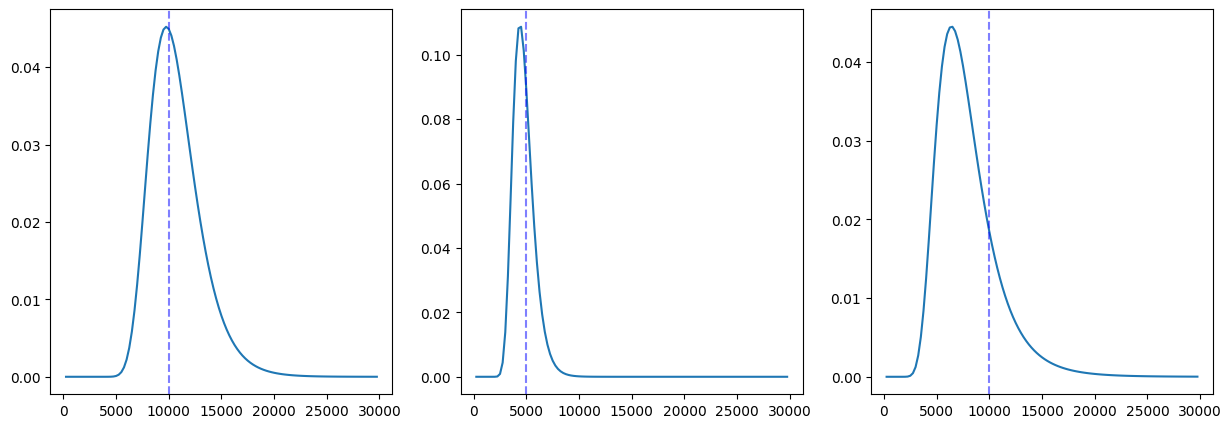

In [12]:
fig, (ax0, ax1, ax2) = plt.subplots(1,3, figsize=(15,5))
ax0.plot(ne_range, np.exp(log_post_smc_slice[0]))
ax0.axvline(10_000, color='blue',linestyle='dashed', alpha=0.5)
ax1.plot(ne_range, np.exp(log_post_smc_slice[1]))
ax1.axvline(5_000, color='blue',linestyle='dashed', alpha=0.5)
ax2.plot(ne_range, np.exp(log_post_smc_slice[2]))
ax2.axvline(10_000, color='blue',linestyle='dashed', alpha=0.5)

In [18]:
# num_edges per time slice
temp = 0
for ts in ts_list:
    print(ts.num_edges - temp)
    temp = ts.num_edges

68
57
23


In [15]:
final_ts = ts_list[-1].simplify()

In [6]:
final_ts

In [ ]:
# coalescence 'density'

In [16]:
from scipy import stats
bin_edges = stats.mstats.mquantiles(ts_list[-1].nodes_time[40:], [0, 1/3, 2/3, 1])
bin_edges

array([4.15716270e+00, 1.00000000e+03, 1.63309812e+03, 4.69530464e+04])

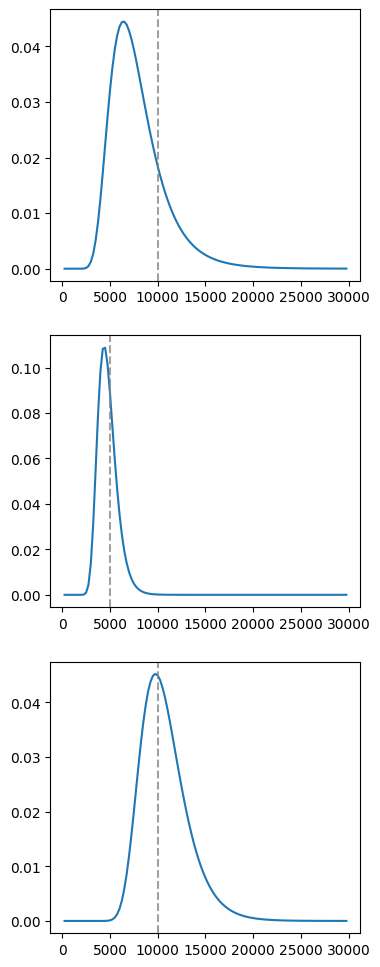

In [13]:
fig, (ax0, ax1, ax2) = plt.subplots(3,1, figsize=(4,12))
ax2.plot(ne_range, np.exp(log_post_smc_slice[0]))
ax2.axvline(10_000, color='gray',linestyle='dashed', alpha=0.75)
ax1.plot(ne_range, np.exp(log_post_smc_slice[1]))
ax1.axvline(5_000, color='gray',linestyle='dashed', alpha=0.75)
ax0.plot(ne_range, np.exp(log_post_smc_slice[2]))
ax0.axvline(10_000, color='gray',linestyle='dashed', alpha=0.75)
fig.tight_layout;

In [17]:
fig.savefig('3_slices.svg', dpi=180)

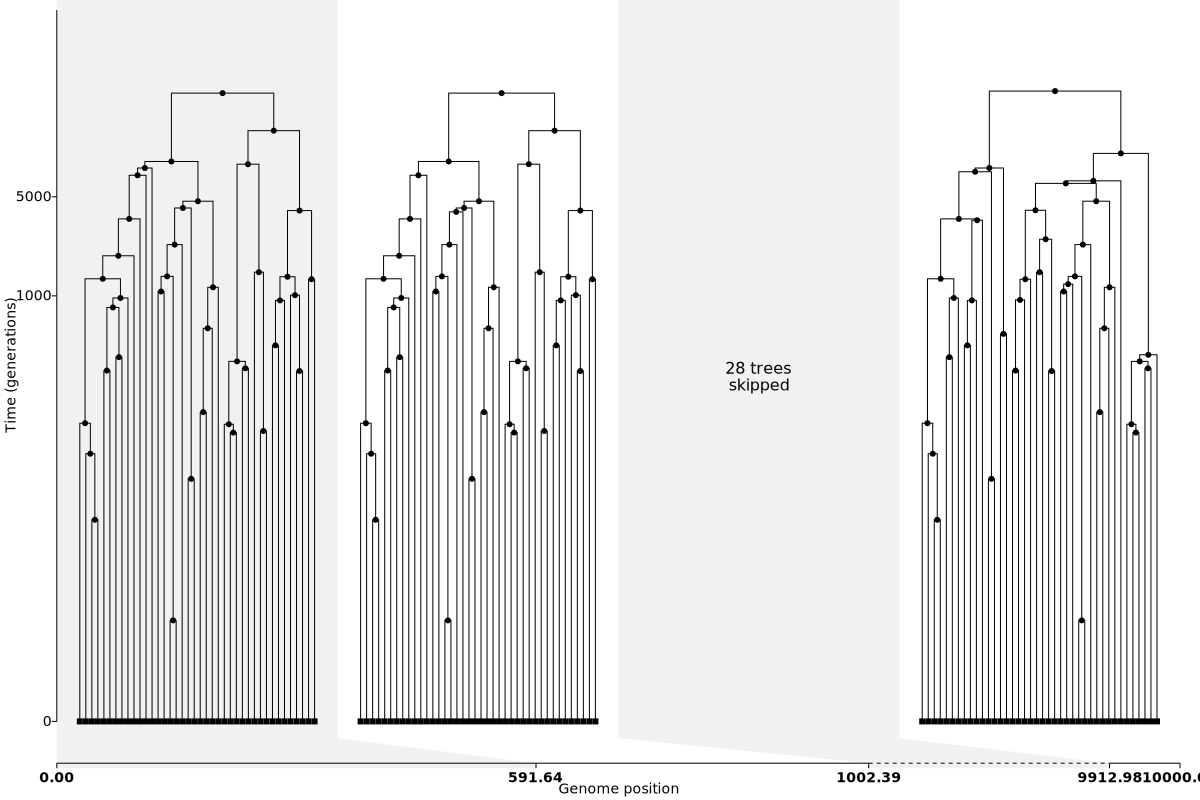

In [121]:
final_ts.draw_svg(
    size=(1200, 800),
    time_scale="log_time",
    node_labels={},
    y_axis=True,
    y_ticks=stop_times[:-1],
    max_num_trees=3,
    path='time_slice.svg'
)